# Make a chi2 spectrum fit with mixed Fermi/HGPS data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pprint import pprint
import astropy.units as u
from astropy.units import Quantity

## The source

~~I'm selecting HESS J1614-518 (source_id 83) / 3FGL J1615.3-5146e.~~

I'm selecting HESS J1303-631 (source_id 61) / 3FGL J1303.0-6312e.

\*\*Many sources from gamma-cat do not have filled in flux data yet (e.g. source_id 83) - I can only work with a select amount of sources until the HGPS catalog is made available to the public.

See from the [Fermi-HGPS repo](https://github.com/gammasky/fermi-hgps-paper/blob/master/analysis/plots/seds/HESS%20J1614-518_3FGL%20J1615.3-5146e_sed.png).

In [2]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL, SourceCatalogHGPS, SourceCatalogObjectHGPS, SourceCatalogGammaCat, SourceCatalogObjectGammaCat

cat_3fgl = SourceCatalog3FGL()
# cat_hgps = SourceCatalogHGPS()  <-- Use gamma-cat until this is made available
cat_gammacat = SourceCatalogGammaCat()

source_3fgl = cat_3fgl['3FGL J1615.3-5146e']
source_gammacat = cat_gammacat['HESS J1303-631']

data_3fgl = source_3fgl.flux_points.table
data_gammacat = source_gammacat.flux_points.table

# Flux units - gamma-cat must be converted from TeV to MeV to match 3FGL
data_3fgl['dnde'] = data_3fgl['dnde'].to('cm-2 s-1 MeV-1')

data_gammacat['e_ref'] = data_gammacat['e_ref'].to('MeV')
data_gammacat['dnde'] = data_gammacat['dnde'].to('cm-2 s-1 MeV-1')
data_gammacat['dnde_errn'] = data_gammacat['dnde_errn'].to('cm-2 s-1 MeV-1')
data_gammacat['dnde_errp'] = data_gammacat['dnde_errp'].to('cm-2 s-1 MeV-1')

# Create flux error
dnde_err = data_3fgl['dnde'] * (data_3fgl['flux_errn'] / data_3fgl['flux'])
data_3fgl['dnde_err'] = dnde_err.to(data_3fgl['dnde'].unit)

dnde_err = data_gammacat['dnde'] * (data_gammacat['dnde_errn'] / data_gammacat['dnde'])
data_gammacat['dnde_err'] = dnde_err.to(data_gammacat['dnde'].unit)
# ^ Did I do this correctly?

In [3]:
data_3fgl.info()

print('\n', source_3fgl.spectral_model.parameters)

<Table length=5>
   name     dtype        unit      n_bad
---------- ------- --------------- -----
     e_ref float64             MeV     0
     e_min float64             MeV     0
     e_max float64             MeV     0
      flux float32     1 / (cm2 s)     1
 flux_errn float32     1 / (cm2 s)     1
 flux_errp float32     1 / (cm2 s)     1
     eflux float32   erg / (cm2 s)     1
eflux_errn float32   erg / (cm2 s)     1
eflux_errp float32   erg / (cm2 s)     1
     is_ul    bool                     0
   flux_ul float64     1 / (cm2 s)     4
  eflux_ul float64   erg / (cm2 s)     4
      dnde float64 1 / (cm2 MeV s)     0
  dnde_err float64 1 / (cm2 MeV s)     1

 ParameterList
Parameter(name='index', value=1.8643473386764526, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.872970958356369e-13, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=6018.2392578125, unit=Unit("MeV"), min=None, max=Non

In [4]:
# data_gammacat.info()

# print('\n', source_gammacat.spectral_model.parameters)

## ~~Combining source data~~

~~data_3fgl + data_gammacat = data_combined~~

In [5]:
# cols = ['e_ref', 'dnde', 'dnde_err']

# data_combined = (data_3fgl[cols])
# data_combined

In [6]:
# for row in data_gammacat[cols]:
#     new_row = []
#     for col in row.as_void():
#         new_row.append(col)

#     data_combined.add_row(new_row)

# data_combined

In [7]:
# print(source_3fgl.energy_range)

# combined_energy_range = Quantity([100, 1e8], 'MeV')
# print('\n', combined_energy_range)

## Plot data and model

We'll be plotting the spectral model for the source as given by `SourceCatalogObject3FGL`.

<Container object of 3 artists>

C:\Users\arjun_000\Anaconda3\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


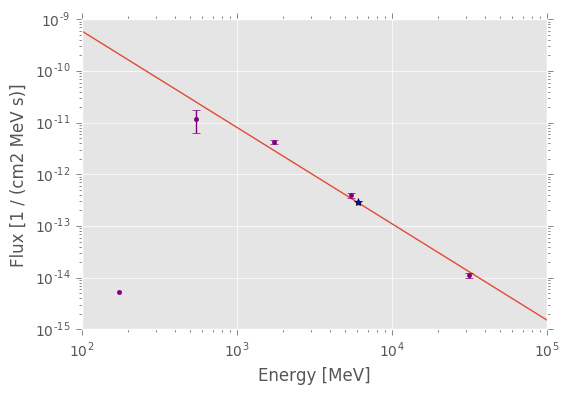

In [8]:
# Defining units
opts = dict(energy_unit='MeV', flux_unit='cm-2 s-1 MeV-1')

# source_3fgl.spectral_model.plot(combined_energy_range, **opts, color='purple')
source_3fgl.spectral_model.plot(source_3fgl.energy_range, **opts)
# Using the combined energy range to stretch to gamma-cat data

p = source_3fgl.spectral_model.parameters
# Spectral model type is PowerLaw

# Plot reference point
plt.plot(p['reference'].value, p['amplitude'].value, '*', color='b')


# Plot 3FGL flux points
plt.errorbar(x=data_3fgl['e_ref'],
             y = data_3fgl['dnde'],
             yerr = data_3fgl['dnde_err'],
             fmt='.',
             color='purple'
            )

# # Plot gamma-cat flux points
# plt.errorbar(x=data_gammacat['e_ref'],
#              y = data_gammacat['dnde'],
#              yerr = data_gammacat['dnde_err'],
#              fmt='.',
#              color='r'
#             )

## Likelihood function - chi2

We have to define the chi2 function for this source (given the spectral model is power-law, ecut will not be a parameter)

In [9]:
print(source_3fgl.spectral_model.parameters)

ParameterList
Parameter(name='index', value=1.8643473386764526, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2.872970958356369e-13, unit=Unit("1 / (cm2 MeV s)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=6018.2392578125, unit=Unit("MeV"), min=None, max=None, frozen=True)

Covariance: None


In [10]:
def chi2(amplitude, index):
    
    dnde_model = source_3fgl.spectral_model.evaluate(
        energy=data_3fgl['e_ref'],
        amplitude=amplitude,
        index=index,
        reference=6018.2392578125 # <-- 3FGL source e_ref minus the units
    ) 

    chi = (data_3fgl['dnde'] - dnde_model) / data_3fgl['dnde_err']
    return np.sum(chi ** 2)

## ML fit with Minuit

In [11]:
from iminuit import Minuit

pars = dict(amplitude=2.872970958356369e-13,  #3FGL amplitude value
            index=1.8643473386764526          #3FGL index value
            )

minuit = Minuit(chi2, **pars)

minuit.print_initial_param()
print("^ Initial parameters")

minuit.migrad() # Performs the minimization
print("^ Optimized parameters for best-fit model")

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: errordef is not given. Default to 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter amplitude is floating but does not have initial step size. Assume 1.
C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: InitialParamWarning: Parameter index is floating but does not have initial step size. Assume 1.


+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,2.87297e-13,1,0,0,,,
2,index,1.86435,1,0,0,,,


^ Initial parameters


C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +1.864347

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +nan
        index = +1.864347

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +0.000000
        index = +nan

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = -nan(ind)
        index = -nan(ind)

C:\Users\arjun_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    amplitude = +nan
        index = +nan

C:\Users\arjun_000\Anaconda3\l

FCN = nan 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amplitude,nan,nan,0,0,,,
2,index,nan,nan,0,0,,,


^ Optimized parameters for best-fit model
